In [1]:
from matplotlib import pyplot as plt 

In [2]:
import json
from pprint import pprint

In [3]:
import json

In [4]:
import re

In [5]:
import numpy as np

In [6]:
def bucket(x, size):
    l = len(x)
    buckets = []
    i = 0
    while i < l:
        buckets.append(sum(x[i:i+size])/len(x[i:i+size]))
        i+=size
    return buckets

In [7]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [8]:
class LogReader():
    def __init__(self, filename, keys):
        self.file = open(f'{filename}')
        self.keys = set(keys)
        self.matches = {}
        for key in keys:
            self.matches[key]=[]
    
    def grab(self):
        line = next(self.file, None)
        while line:
            split = line.strip().split('=')
            if len(split)==2:
                query = split[0]
                value = float(split[1])
                if query in self.keys:
                    self.matches[query].append(value)
            line = next(self.file, None)
        return self.matches

In [9]:
tasks = [
    ('atac_region', 'gene'),
    ('gene', 'atac_region'),
    ('gene', 'protein_name'),
    ('protein_name', 'gene'),
]

In [10]:
base_keys = [
    'train zero one loss',
    'train value loss',
    'train prediction loss',
    'validation zero one loss',
    'validation value loss',
    'validation prediction loss',
]

keys = []
for key in base_keys:
    for task in tasks:
        keys.append(f'{key} {task}')

In [53]:
keys += [
    'Outer step',
    'Batch'
]

In [54]:
readers = {}
matches = {}

#### Timestamp of run

In [55]:
timestamps = [
    '20211102-1454',
    '20211103-0958',
    '20211103-1533',
]
files = [f'logs/train_earl_{tmstp}.log' for tmstp in timestamps]

In [56]:
for file in files:
    if file not in readers:
        readers[file] = LogReader(file, keys)
        matches = readers[file].grab()

In [57]:
for tmstp in timestamps:
    file = f'logs/train_earl_{tmstp}.log'
    matches = readers[file].grab()
    print(tmstp)
    for task in tasks:
        validation_losses = matches[f'validation prediction loss {task}']
        print(task, ' '.join([f'{loss:.3f}' for loss in validation_losses[-5:]]))
    print('----')

20211102-1454
('atac_region', 'gene') 0.385 0.352 0.352 0.398 0.458
('gene', 'atac_region') 0.049 0.059 0.047 0.069 0.059
('gene', 'protein_name') 0.257 0.440 0.363 0.317 0.326
('protein_name', 'gene') 0.291 0.459 0.250 0.278 0.303
----
20211103-0958
('atac_region', 'gene') 0.288 0.339 0.457 0.247 0.469
('gene', 'atac_region') 0.064 0.051 0.096 0.067 0.087
('gene', 'protein_name') 0.360 0.369 0.463 0.403 0.408
('protein_name', 'gene') 0.495 0.325 0.251 0.398 0.388
----
20211103-1533
('atac_region', 'gene') 56.241 41.394 74.314 59.364 64.108
('gene', 'atac_region') 60.490 59.214 61.667 58.556 57.705
('gene', 'protein_name') 32.498 29.634 28.297 31.434 27.463
('protein_name', 'gene') 39.407 42.322 74.707 44.483 63.669
----


## Select File

In [76]:
idx = 0

## Get matching log lines

In [77]:
file = files[idx]
matches = readers[file].grab()

## Parameters of this run

In [78]:
pprint(json.load(open(f'logs/earl_params_{timestamps[idx]}.json')))

{'atac_ones_weight': 1,
 'checkpoint': 40,
 'device': 'cuda:0',
 'gene_ones_weight': 1,
 'inner_lr': 0.001,
 'inner_steps': 5,
 'layers': [['SAGEConv', {'out_channels': 128}],
            ['SAGEConv', {'out_channels': 128}],
            ['SAGEConv', {'out_channels': 128}],
            ['SAGEConv', {'out_channels': 128}],
            ['SAGEConv', {'out_channels': 128}]],
 'mode': 'reptile',
 'n_steps': 10000,
 'out_mlp': {'bias': True,
             'dim_in': 128,
             'dim_inner': 512,
             'dim_out': 1,
             'num_layers': 3},
 'outer_lr': 0.1,
 'target_heads': True,
 'train_batch_size': 10,
 'validation_batch_size': 10}


## Current Step

In [79]:
if len(matches['Outer step'])>0:
    batch = matches['Outer step'][-1]
    print(batch)
elif len(matches['Batch'])>0:
    epoch = matches['Batch'][-1]
    print(epoch)

4058.0


## Training loss

('atac_region', 'gene') 0.3962
('gene', 'atac_region') 0.0970
('gene', 'protein_name') 0.2708
('protein_name', 'gene') 0.3429


<Figure size 1080x720 with 0 Axes>

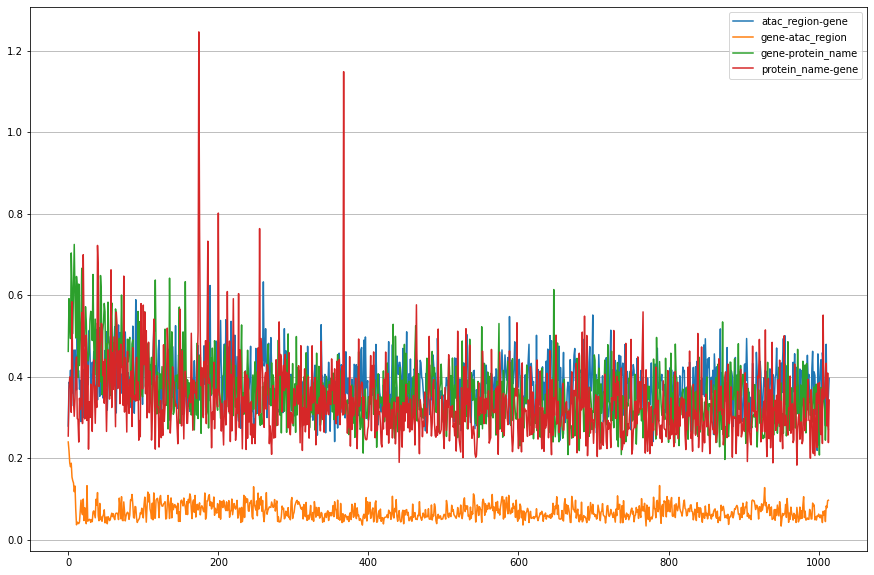

In [80]:
plt.figure(figsize=(15,10))
fig,ax = plt.subplots(figsize=(15,10))
plt.grid(axis='y')

for task in tasks:
    training_loss = matches[f'train prediction loss {task}']
    ax.plot(training_loss[0:], label=f'{task[0]}-{task[1]}')
    print(task, f'{training_loss[-1]:.4f}')
_=ax.legend()


('atac_region', 'gene') 0.39621091783046725
('gene', 'atac_region') 0.09702485352754593
('gene', 'protein_name') 0.2708394393324852
('protein_name', 'gene') 0.3429051727056504


<Figure size 1080x720 with 0 Axes>

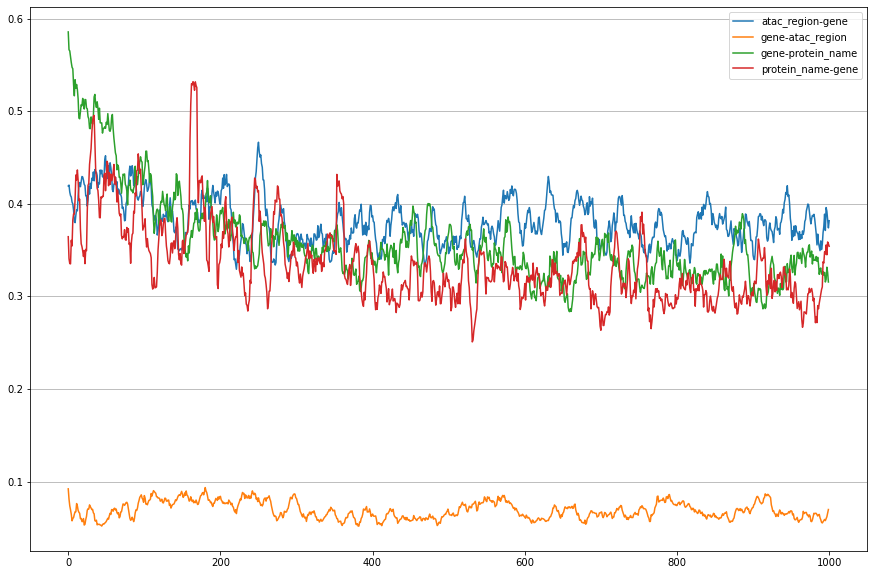

In [81]:
plt.figure(figsize=(15,10))
fig,ax = plt.subplots(figsize=(15,10))
plt.grid(axis='y')

for task in tasks:
    training_loss = matches[f'train prediction loss {task}']
    ax.plot(moving_average(training_loss[5:],10), label=f'{task[0]}-{task[1]}')
    print(task, training_loss[-1])
_=ax.legend()


## Validation Loss

('atac_region', 'gene') 0.45814512968063353
('gene', 'atac_region') 0.05868973284959793
('gene', 'protein_name') 0.32583485543727875
('protein_name', 'gene') 0.3034035012125969


<Figure size 1080x720 with 0 Axes>

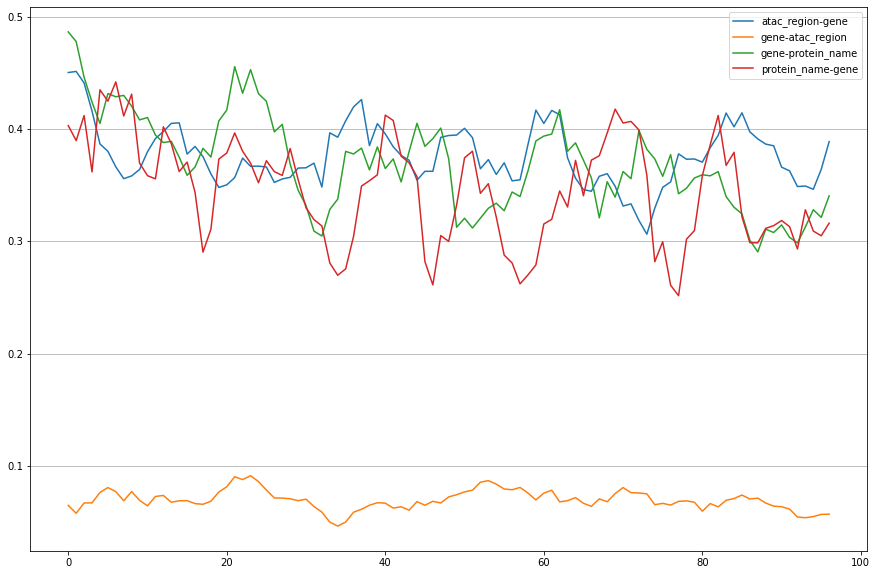

In [82]:
plt.figure(figsize=(15,10))
fig,ax = plt.subplots(figsize=(15,10))
plt.grid(axis='y')

for task in tasks:
    validation_loss = matches[f'validation prediction loss {task}']
    _=ax.plot(moving_average(validation_loss,5), label=f'{task[0]}-{task[1]}')
#     _=ax.plot(validation_loss, label=f'{task[0]}-{task[1]}')
    print(task, validation_loss[-1])
_=ax.legend()

## Sample predictions

In [83]:
import time

In [84]:
prediction_file = open(f'logs/train_earl_prediction_sample_{timestamps[idx]}.log')

for line in prediction_file:
    print(line.strip(), flush=True)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Task: ('protein_name', 'gene')
--------------------------------------------------------------------------------
batch 4039 0      pred,y:   0.000 0.000
batch 4039 1      pred,y:   0.845 0.000
batch 4039 2      pred,y:   0.000 0.000
batch 4039 3      pred,y:   0.000 0.000
batch 4039 4      pred,y:   0.000 0.000
batch 4039 5      pred,y:   0.000 0.000
batch 4039 6      pred,y:   0.000 0.000
batch 4039 7      pred,y:   0.000 0.000
batch 4039 8      pred,y:   0.000 0.000
batch 4039 9      pred,y:   0.000 0.000
batch 4039 10     pred,y:   0.000 0.000
batch 4039 11     pred,y:   0.000 0.940
batch 4039 12     pred,y:   0.000 0.000
batch 4039 13     pred,y:   0.000 0.000
batch 4039 14     pred,y:   1.176 0.000
batch 4039 15     pred,y:   0.000 0.000
batch 4039 16     pred,y:   0.000 0.000
batch 4039 17     pred,y:   0.000 0.000
batch 4039 18     pred,y:   0.000 0.000
batch 4039 19     pred,y:   0.000 0.000
batch 4039 20     pred,y:   0.000 0.940
batch 4039 21     pred,y:   1.066 0.000
batch 40

batch 4039 203    pred,y:   0.796 0.000
batch 4039 204    pred,y:   0.000 0.000
batch 4039 205    pred,y:   0.000 0.000
batch 4039 206    pred,y:   0.954 0.000
batch 4039 207    pred,y:   0.000 0.000
batch 4039 208    pred,y:   0.000 0.000
batch 4039 209    pred,y:   0.000 0.000
batch 4039 210    pred,y:   0.000 0.000
batch 4039 211    pred,y:   0.000 0.000
batch 4039 212    pred,y:   0.000 0.000
batch 4039 213    pred,y:   0.000 0.000
batch 4039 214    pred,y:   0.875 0.940
batch 4039 215    pred,y:   0.000 0.000
batch 4039 216    pred,y:   0.000 0.000
batch 4039 217    pred,y:   0.000 0.000
batch 4039 218    pred,y:   0.000 0.000
batch 4039 219    pred,y:   0.000 0.000
batch 4039 220    pred,y:   1.805 0.000
batch 4039 221    pred,y:   0.000 0.000
batch 4039 222    pred,y:   0.899 0.000
batch 4039 223    pred,y:   0.000 0.000
batch 4039 224    pred,y:   0.921 0.000
batch 4039 225    pred,y:   0.000 0.000
batch 4039 226    pred,y:   0.000 0.000
batch 4039 227    pred,y:   0.889 0.000


batch 4039 103    pred,y:   0.000 0.000
batch 4039 104    pred,y:   0.864 1.042
batch 4039 105    pred,y:   0.767 1.042
batch 4039 106    pred,y:   0.415 0.000
batch 4039 107    pred,y:   0.585 0.799
batch 4039 108    pred,y:   0.900 0.000
batch 4039 109    pred,y:   0.716 0.799
batch 4039 110    pred,y:   0.000 0.651
batch 4039 111    pred,y:   0.448 0.000
batch 4039 112    pred,y:   0.627 0.651
batch 4039 113    pred,y:   0.000 0.477
batch 4039 114    pred,y:   0.000 0.799
batch 4039 115    pred,y:   0.899 1.042
batch 4039 116    pred,y:   1.693 0.799
batch 4039 117    pred,y:   1.331 1.541
batch 4039 118    pred,y:   0.521 0.651
batch 4039 119    pred,y:   0.000 0.000
batch 4039 120    pred,y:   1.056 0.651
batch 4039 121    pred,y:   0.000 0.477
batch 4039 122    pred,y:   0.391 0.651
batch 4039 123    pred,y:   0.726 0.477
batch 4039 124    pred,y:   0.000 0.267
batch 4039 125    pred,y:   0.000 0.000
batch 4039 126    pred,y:   0.812 0.799
batch 4039 127    pred,y:   0.674 0.799


batch 4039 170    pred,y:   0.000 0.000
batch 4039 171    pred,y:   0.000 0.000
batch 4039 172    pred,y:   0.000 1.336
batch 4039 173    pred,y:   0.000 0.000
batch 4039 174    pred,y:   0.000 0.000
batch 4039 175    pred,y:   0.000 0.000
batch 4039 176    pred,y:   0.000 0.000
batch 4039 177    pred,y:   1.626 0.000
batch 4039 178    pred,y:   0.000 0.000
batch 4039 179    pred,y:   0.000 0.000
batch 4039 180    pred,y:   0.000 0.000
batch 4039 181    pred,y:   0.000 0.000
batch 4039 182    pred,y:   0.000 0.000
batch 4039 183    pred,y:   0.000 0.000
batch 4039 184    pred,y:   0.000 0.000
batch 4039 185    pred,y:   0.000 0.000
batch 4039 186    pred,y:   1.432 0.000
batch 4039 187    pred,y:   0.000 0.000
batch 4039 188    pred,y:   0.000 0.000
batch 4039 189    pred,y:   0.000 0.000
batch 4039 190    pred,y:   1.417 0.000
batch 4039 191    pred,y:   0.000 0.000
batch 4039 192    pred,y:   1.386 0.000
batch 4039 193    pred,y:   0.000 0.000
batch 4039 194    pred,y:   0.000 0.000


batch 4039 70     pred,y:   0.121 1.000
batch 4039 71     pred,y:   0.027 0.000
batch 4039 72     pred,y:   0.009 0.000
batch 4039 73     pred,y:   0.010 0.000
batch 4039 74     pred,y:   0.081 0.000
batch 4039 75     pred,y:   0.007 0.000
batch 4039 76     pred,y:   0.019 0.000
batch 4039 77     pred,y:   0.016 0.000
batch 4039 78     pred,y:   0.023 0.000
batch 4039 79     pred,y:   0.011 0.000
batch 4039 80     pred,y:   0.011 0.000
batch 4039 81     pred,y:   0.011 0.000
batch 4039 82     pred,y:   0.013 0.000
batch 4039 83     pred,y:   0.015 0.000
batch 4039 84     pred,y:   0.019 0.000
batch 4039 85     pred,y:   0.027 0.000
batch 4039 86     pred,y:   0.012 0.000
batch 4039 87     pred,y:   0.015 0.000
batch 4039 88     pred,y:   0.005 0.000
batch 4039 89     pred,y:   0.017 0.000
batch 4039 90     pred,y:   0.012 0.000
batch 4039 91     pred,y:   0.004 0.000
batch 4039 92     pred,y:   0.046 0.000
batch 4039 93     pred,y:   0.017 0.000
batch 4039 94     pred,y:   0.013 0.000


batch 4039 275    pred,y:   0.011 0.000
batch 4039 276    pred,y:   0.149 0.000
batch 4039 277    pred,y:   0.074 0.000
batch 4039 278    pred,y:   0.021 0.000
batch 4039 279    pred,y:   0.022 0.000
batch 4039 280    pred,y:   0.013 0.000
batch 4039 281    pred,y:   0.015 0.000
batch 4039 282    pred,y:   0.011 0.000
batch 4039 283    pred,y:   0.104 0.000
batch 4039 284    pred,y:   0.018 0.000
batch 4039 285    pred,y:   0.017 0.000
batch 4039 286    pred,y:   0.011 0.000
batch 4039 287    pred,y:   0.010 0.000
batch 4039 288    pred,y:   0.024 0.000
batch 4039 289    pred,y:   0.021 0.000
batch 4039 290    pred,y:   0.013 0.000
batch 4039 291    pred,y:   0.012 0.000
batch 4039 292    pred,y:   0.012 0.000
batch 4039 293    pred,y:   0.011 0.000
batch 4039 294    pred,y:   0.017 0.000
batch 4039 295    pred,y:   0.010 0.000
batch 4039 296    pred,y:   0.017 0.000
batch 4039 297    pred,y:   0.054 0.000
batch 4039 298    pred,y:   0.012 0.000
batch 4039 299    pred,y:   0.038 0.000
